In [91]:
# The goal of this project is to build a Neural Network that is able to predict if an email is spam.
# To do this, I will be using Keras. 

In [92]:
import numpy as np
import pandas as pd 

import keras

import matplotlib
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding

In [93]:
df_spam = pd.read_csv('C:/Users/louri/OneDrive/Desktop/datasets/spam_or_not.csv')
df_spam.head(10)

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0
5,i just had to jump in here as carbonara is on...,0
6,the scotsman NUMBER august NUMBER playboy want...,0
7,martin adamson wrote isn t it just basically a...,0
8,the scotsman thu NUMBER aug NUMBER meaningful ...,0
9,i have been trying to research via sa mirrors ...,0


In [94]:
df_spam.describe(include='all')

,email,label
count,2999,3000.000000
unique,2872,NaN
top,url URL date not supplied URL,NaN
freq,10,NaN
mean,NaN,0.166667
std,NaN,0.372740
min,NaN,0.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,0.000000


In [95]:
df_spam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
email    2999 non-null object
label    3000 non-null int64
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [96]:
# We notice that there is one row where the email cell is empty, let's remove it...

df_spam.dropna(inplace=True)

In [97]:
# Now, the first step is to prepare our data. To do so, I create a class to vectorize our text corpus which contains all the 
# emails. Using OOP is not mandatory here but i like using it so my code better organized and reusable.

class tokenizer():
    
    def __init__(self, df, nb_words, max_len):
        self.df = df
        self.nb_words = nb_words
        # I use nb_words to take only the 1000 most common words
        self.max_len = max_len 
        # I use max_len to fix the dimension of the tensors representing emails
        self.tokenizer = Tokenizer(num_words = self.nb_words)
        self.word_index = {}
        
    def get_text_sequences(self, column_name): 
        
        self.word_index = self.tokenizer.fit_on_texts(self.df[column_name])
        # fit_on_texts method fill the word index internal dictionary word_index. The lower the word index the more frequent it is
        sequences = self.tokenizer.texts_to_sequences(self.df[column_name])
        # Then, I create a list containing the sequences of integers for each email. Each integer is the index number of the
        # corresponding word from word_index.
        padded_sequences = pad_sequences(sequences, maxlen=self.max_len)     
        # I pad all the sequences to have the max lenght specified during the initialization
        return padded_sequences

    def get_tokenizer(self):
        return self.tokenizer 
    
    def get_word_index(self):
        return self.tokenizer.word_index
        

In [98]:
y = df_spam.label.copy()

tz = tokenizer(df_spam, nb_words=1000, max_len=300)

X = tz.get_text_sequences('email')
tokenizer = tz.get_tokenizer()
word_index = tz.get_word_index()
print ('We have', len(word_index), 'distinct words in our corpus')

We have 33672 distinct words in our corpus


In [99]:
# Here is what the sequence of an email looks like
X[0,:]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  88, 576,   1, 379,   1,   1,   1,   1,
         1,  21, 534,   1, 174,  90, 931,   1,   1, 174,   8,  33,  25,
        15, 289,  14,  71,  13,  10, 142,  62, 182,  56, 206,  15,  10,
         2, 373,   5,   2, 856,   1,   1,   1, 856,  13, 856,  38, 150,
         1,   1, 989,   1,   1,   1, 856,  38, 150,   1,   1, 989,   1,
         1,   1,   1, 584,   1,   1,   1,   1,   1,   1,   1, 28

In [100]:
# Now, I create and configure my model..

model = Sequential()
model.add(Embedding(len(word_index)+1, 100, input_length=300))
# The Embedding layer transform each word represented by its integer index to a vector of dimension 100. 
model.add(Flatten())
# I flatten the input 
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 300, 100)          3367300   
_________________________________________________________________
flatten_5 (Flatten)          (None, 30000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 30001     
Total params: 3,397,301
Trainable params: 3,397,301
Non-trainable params: 0
_________________________________________________________________


In [101]:
# Now that our model is ready to be used, let's split our data into training and validation sets...
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [102]:
model.compile(optimizer='adagrad', loss='binary_crossentropy', metrics=['acc'])
# To train my model , I used Adagrad optimizer and binary_crossentropy for the loss function.

history = model.fit(X_train, y_train, epochs=4, batch_size=32, validation_split=0.2)

C:\Users\louri\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1919 samples, validate on 480 samples
Epoch 1/4
1919/1919 [==============================] - 1s 740us/step - loss: 0.2091 - acc: 0.9239 - val_loss: 0.0849 - val_acc: 0.9771
Epoch 2/4
1919/1919 [==============================] - 1s 619us/step - loss: 0.0502 - acc: 0.9859 - val_loss: 0.0560 - val_acc: 0.9812
Epoch 3/4
1919/1919 [==============================] - 1s 599us/step - loss: 0.0306 - acc: 0.9911 - val_loss: 0.0450 - val_acc: 0.9854
Epoch 4/4
1919/1919 [==============================] - 1s 594us/step - loss: 0.0214 - acc: 0.9958 - val_loss: 0.0403 - val_acc: 0.9917


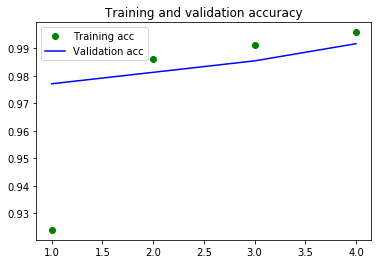

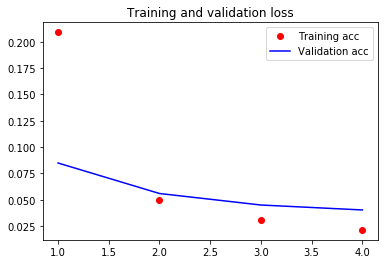

In [103]:
# Now, I want to visualize how accuracy and loss evolve during the training and validation process..

accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, accuracy, 'bo', color='green', label='Training acc')
plt.plot(epochs, val_accuracy, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend();
plt.show()

plt.plot(epochs, loss, 'bo', color='red', label='Training acc')
plt.plot(epochs, val_loss, 'b', label='Validation acc')
plt.title('Training and validation loss')
plt.legend();
plt.show()

In [104]:
model.evaluate(X_test, y_test)
# loss value & acc metrics

600/600 [==============================] - 0s 32us/step


[0.03632817463328441, 0.9866666793823242]